## Running PhotoD with LSDB

In [6]:
import os

default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path

import jax
import lsdb
from lsdb import BoxSearch
import matplotlib.pyplot as plt
import nested_pandas as npd
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
from dask import delayed
from dask.distributed import Client, get_worker
# from dustmaps import sfd
from scipy.interpolate import griddata
from photod.bayes import makeBayesEstimates3d
from photod.locus import LSSTsimsLocus, subsampleLocusData, get3DmodelList
from photod.parameters import GlobalParams

# dustmaps_cache = '/mnt/beegfs/scratch/data/dustmaps'
# Path(dustmaps_cache).mkdir(exist_ok=True, parents=True)
# import dustmaps.config; dustmaps.config.config['data_dir'] = dustmaps_cache
# sfd.fetch()

In [4]:
prior_map_url = "/mnt/beegfs/scratch/data/priors/hats/s82_priors/"
prior_map_catalog = lsdb.read_hats(prior_map_url)
prior_map_catalog

,rmag,kde,xGrid,yGrid,Norder,Dir,Npix
npartitions=207,,,,,,,
"Order: 5, Pixel: 0",double[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...


In [9]:
df = lsdb.read_hats("/mnt/beegfs/scratch/data/Gaia-SDSS/hats/Gaia-SDSS_w_extinctions/", search_filter=BoxSearch(ra=(-53, 61), dec=(-2., 2.)))
df

,random_index,ra,dec,phot_g_mean_mag,parallax,parallax_error,source_id,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,objid,type,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,Norder,Dir,Npix
npartitions=13,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 1, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 2, Pixel: 48",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 8",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: >)

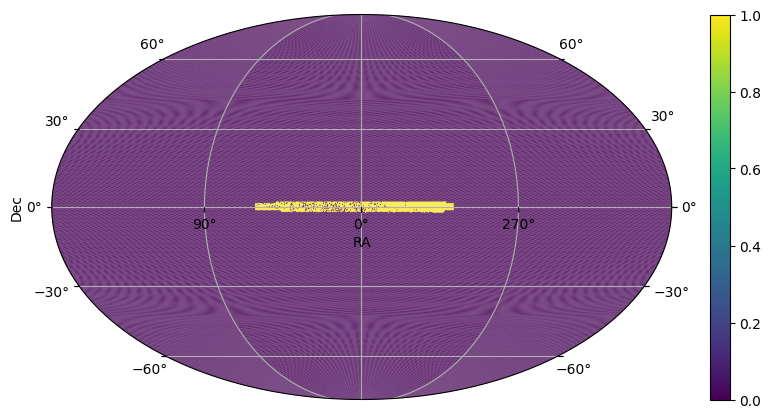

In [10]:
df.skymap(lambda df, a: np.log10(len(df)+1), order=9)

In [17]:
def merging_function(partition, map_partition, partition_pixel, map_pixel, globalParams, worker_dict, *kwargs):
    priorGrid = {}
    for rind, r in enumerate(np.sort(map_partition["rmag"].to_numpy())):
        # interpolate prior map onto locus Mr-FeH grid
        Z = map_partition[map_partition["rmag"] == r]
        Zval = np.frombuffer(Z.iloc[0]["kde"], dtype=np.float64).reshape((96, 36))
        X = np.frombuffer(Z.iloc[0]["xGrid"], dtype=np.float64).reshape((96, 36))
        Y = np.frombuffer(Z.iloc[0]["yGrid"], dtype=np.float64).reshape((96, 36))
        points = np.array((X.flatten(), Y.flatten())).T
        values = Zval.flatten()
        # actual (linear) interpolation
        priorGrid[rind] = griddata(
            points, values, (globalParams.locusData["FeH"], globalParams.locusData[globalParams.MrColumn]), method="linear", fill_value=0
        )
    gpu_device = jax.devices()[worker_dict[get_worker().id]]
    with jax.default_device(gpu_device):
        priorGrid = jax.numpy.array(list(priorGrid.values()))
        estimatesDf, _ = makeBayesEstimates3d(partition, priorGrid, globalParams, batchSize=100)
    # Append ra and dec to be able to later crossmatch
    return pd.concat([partition[["ra", "dec", "r_med_geo", "r_med_photogeo", "parallax_over_error", "rmag", "umag", "gr",]], npd.NestedFrame(estimatesDf)], axis=1)

In [18]:
locus_path = "../../data/MSandRGBcolors_v1.3.txt"
fitColors = ("ug", "gr", "ri", "iz")
LSSTlocus = LSSTsimsLocus(fixForStripe82=False, datafile=locus_path)
OKlocus = LSSTlocus[(LSSTlocus["gi"] > 0.2) & (LSSTlocus["gi"] < 3.55)]
locusData = subsampleLocusData(OKlocus, kMr=10, kFeH=2)
ArGridList, locus3DList = get3DmodelList(locusData, fitColors)
globalParams = GlobalParams(fitColors, locusData, ArGridList, locus3DList)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


In [19]:
quantile_cols = [f"{statisticsName}_quantile_{quantile}" for statisticsName in ["Mr","FeH","Ar","Qr"] for quantile in ["lo","median","hi"]]
estimate_cols = sorted([*quantile_cols,"MrdS","FeHdS","ArdS"])
col_names = ["ra","dec","r_med_geo","r_med_photogeo","parallax_over_error","rmag","umag","gr","glon","glat","chi2min",*estimate_cols]
meta = npd.NestedFrame.from_dict({ col: pd.Series([], dtype=np.float32) for col in col_names })
meta.index.name = "_healpix_29"
meta

,ra,dec,r_med_geo,r_med_photogeo,parallax_over_error,rmag,umag,gr,glon,glat,...,FeH_quantile_lo,FeH_quantile_median,FeHdS,Mr_quantile_hi,Mr_quantile_lo,Mr_quantile_median,MrdS,Qr_quantile_hi,Qr_quantile_lo,Qr_quantile_median
_healpix_29,,,,,,,,,,,,,,,,,,,,,


In [20]:
def get_worker_dict():
    res = df._ddf.partitions[0:5].map_partitions(lambda df: pd.DataFrame.from_dict({"workers":[get_worker().id]}), meta={"workers": object}).compute()
    worker_ids = np.unique(res["workers"].to_numpy())
    worker_dict = {id: i for i, id in enumerate(worker_ids)}
    print(worker_dict)
    return worker_dict

In [21]:
with Client(n_workers=4) as client:
    worker_dict = get_worker_dict()
    print(worker_dict)
    delayed_global_params = delayed(globalParams)
    merge_lazy = df.merge_map(prior_map_catalog, merging_function, globalParams=delayed_global_params, worker_dict=worker_dict, meta=meta)
    xmatch_result = merge_lazy.compute()
xmatch_result

/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/distributed/node.py:173: ResourceWarning: unclosed <socket.socket fd=187, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35213 instead
  warnings.warn(


{'Worker-1d5fee8a-196f-474a-8acf-e8e734c4d643': 0, 'Worker-90f9c26d-ab56-4188-849a-15451e3eb018': 1, 'Worker-9c79bd63-d442-4661-b281-23b75c4e5409': 2, 'Worker-c7b90200-9ad2-4604-9ab7-c1c652551aad': 3}
{'Worker-1d5fee8a-196f-474a-8acf-e8e734c4d643': 0, 'Worker-90f9c26d-ab56-4188-849a-15451e3eb018': 1, 'Worker-9c79bd63-d442-4661-b281-23b75c4e5409': 2, 'Worker-c7b90200-9ad2-4604-9ab7-c1c652551aad': 3}


/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 78.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Task exception was never retrieved
future: <Task finished name='Task-1760' coro=<Client._gather.<locals>.wait() done, defined at /nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit
2024-12-14 21:40:10,913 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled

(43435, 29)


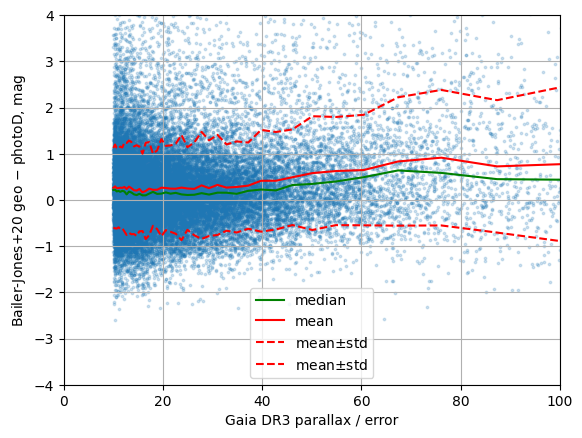

In [9]:
def pc_to_distmod(d):
    return 5.0 * np.log10(d / 10.0)

plot_samples = None
poe_window = 1000

df = xmatch_result.copy()
coord = SkyCoord(df["ra"], df["dec"], unit="deg")
# Coeeficient is for SDSS r-band, RV=3.1
# Taken from table 6, Shlafly & Finkbeiner 2011
# https://ui.adsabs.harvard.edu/abs/2011ApJ...737..103S/abstract
df["sfd_Ar"] = 2.285 * sfd.SFDQuery()(coord)
df["Mr_gaia_geo"] = df["rmag"] - pc_to_distmod(df["r_med_geo"]) - df["sfd_Ar"]
df["Mr_gaia_photogeo"] = df["rmag"] - pc_to_distmod(df["r_med_photogeo"]) - df["sfd_Ar"]
df = df.sort_values("parallax_over_error").query(
    "Mr_gaia_geo > 4"
    " and Mr_gaia_photogeo > 4"
    " and umag < 21"
    " and 0.2 < gr < 0.6"
    " and parallax_over_error >= 10"
)
print(df.shape)

poe = df["parallax_over_error"].to_numpy()

# obs = df["rmag"].to_numpy() - df["Qr_quantile_median"].to_numpy()
# mod = pc_to_distmod(df["r_med_geo_gaia_dist"]).to_numpy()
obs = df["Mr_quantile_median"].to_numpy()
mod = df["Mr_gaia_geo"].to_numpy()

residuals = mod - obs

poe_grid = poe[::poe_window][:-1]
medians = np.nanmedian(
    residuals[:len(residuals) // poe_window * poe_window].reshape(-1, poe_window),
    axis=1,
)
mean = np.nanmean(
    residuals[:len(residuals) // poe_window * poe_window].reshape(-1, poe_window),
    axis=1,
)
std = np.nanstd(
    residuals[:len(residuals) // poe_window * poe_window].reshape(-1, poe_window),
    axis=1,
)

idx_samples = None if plot_samples is None else np.random.default_rng(0).choice(len(residuals), plot_samples, replace=False)
plt.scatter(poe[idx_samples], residuals[idx_samples], marker='o', s=3, alpha=0.2)

plt.plot(poe_grid, medians, '-', color='green', label='median')
plt.plot(poe_grid, mean, '-', color='red', label='mean')
plt.plot(poe_grid, np.stack([mean - std, mean+std], axis=-1), '--', color='red', label=r'mean$\pm$std')

plt.xlim(0, 100)
plt.ylim(-4, 4)
plt.xlabel("Gaia DR3 parallax / error")
plt.ylabel("Bailer-Jones+20 geo $-$ photoD, mag")
plt.grid()
plt.legend()
plt.savefig("MYPLOT.png")

In [10]:
np.mean(df["Mr_quantile_median"] + df["Ar_quantile_median"] - df["Qr_quantile_median"])

np.float32(-0.011516952)